In [2]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [3]:
def bar_plot(values, names, title, x_label, y_label, colors, use_legend_instead=False, ylim=None):
    plt.figure(figsize=(8, 5))
    if use_legend_instead:
        for i, value in enumerate(values):
            plt.bar(i, value, color=colors[i], alpha=0.7, edgecolor='black', width=0.5, label=names[i])
        plt.legend(loc='upper left')
        plt.xticks(range(len(names)), [''] * len(names))
    else:
        plt.bar(names, values, color=colors[0], alpha=0.7, edgecolor='black', width=0.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.ylim(0, max(values) * 1.1)
    if ylim:
        plt.ylim(ylim)
    for i, value in enumerate(values):
        plt.text(i, value, str(round(value, 3)), ha='center', va='bottom')
    plt.show()

def plot_data(x, ys, colors, names, title, x_label, y_label):
    plt.figure(figsize=(8, 5))
    for y, color, name in zip(ys, colors, names):
        new_x = x[:len(y)]
        plt.plot(new_x, y, color=color, marker='o', label=name)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

In [12]:
results_path = '/home/munz/school/research_methods/results.csv'
results = pd.read_csv(results_path)
results = results.sort_values(by=['data', 'num_batches'], ascending=[True, True])
results['ftrain_size'] = results['train_size'] + 45
results[:60]

,data,num_batches,accuracy,time_elapsed,train_size,ftrain_size
0,baseline,0,0.5100,00:16.72,5,50
1,baseline,1,0.8383,00:34.29,305,350
2,baseline,2,0.8523,00:51.41,605,650
3,baseline,3,0.8648,01:09.51,905,950
4,baseline,4,0.8648,01:27.97,1205,1250
5,baseline,5,0.8594,01:46.22,1505,1550
6,baseline,6,0.8754,02:05.8,1805,1850
7,baseline,7,0.8402,02:23.52,2105,2150
8,baseline,8,0.8848,02:40.97,2405,2450
9,baseline,9,0.8855,02:58.57,2705,2750


In [10]:
for idx, row in results.iterrows():
    if row['train_size'] == 5:
        results.at[idx, 'accuracy'] = 0.51

results.to_csv(results_path, index=False)

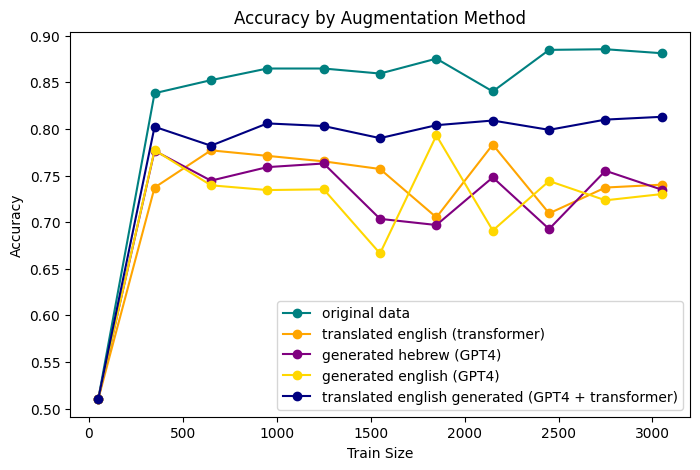

In [11]:
x = results[results['data'] == 'baseline']['ftrain_size'].values
y_baseline = results[results['data'] == 'baseline']['accuracy'].values
y_translated = results[results['data'] == 'translated']['accuracy'].values
y_generated_hebrew = results[results['data'] == 'generated_hebrew']['accuracy'].values
y_generated_english = results[results['data'] == 'generated_english']['accuracy'].values
y_generated_english_translated = results[results['data'] == 'generated_english_translated']['accuracy'].values

ys = [y_baseline, y_translated, y_generated_hebrew, y_generated_english, y_generated_english_translated]
colors = ['teal', 'orange', 'purple', 'gold', 'navy']
names = ['original data', 'translated english (transformer)', 'generated hebrew (GPT4)', 'generated english (GPT4)', 'translated english generated (GPT4 + transformer)']
title = 'Accuracy by Augmentation Method'
x_label = 'Train Size'
y_label = 'Accuracy'

plot_data(x, ys, colors, names, title, x_label, y_label)

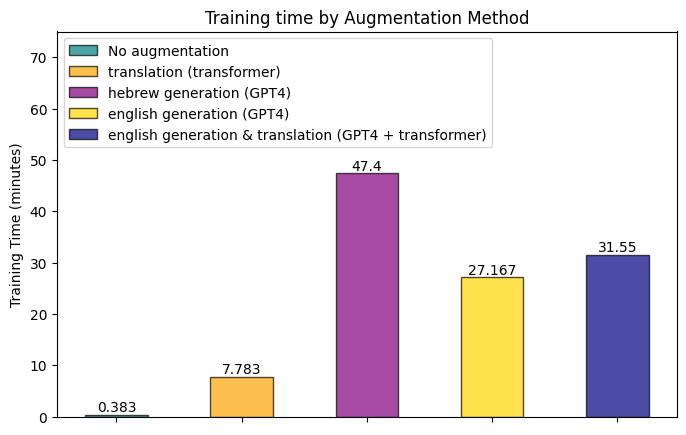

In [129]:
values = [23, 197+270, 196+2648, 196+1434, 196+1434+263]
values = np.array(values) / 60
names = ['No augmentation', 'translation (transformer)', 'hebrew generation (GPT4)', 'english generation (GPT4)', 'english generation & translation (GPT4 + transformer)']
title = 'Training time by Augmentation Method'
x_label = 'Augmentation Method'
y_label = 'Training Time (minutes)'
colors = ['teal', 'orange', 'purple', 'gold', 'navy']

bar_plot(values, names, title, x_label, y_label, colors, use_legend_instead=True, ylim=(0, 75))

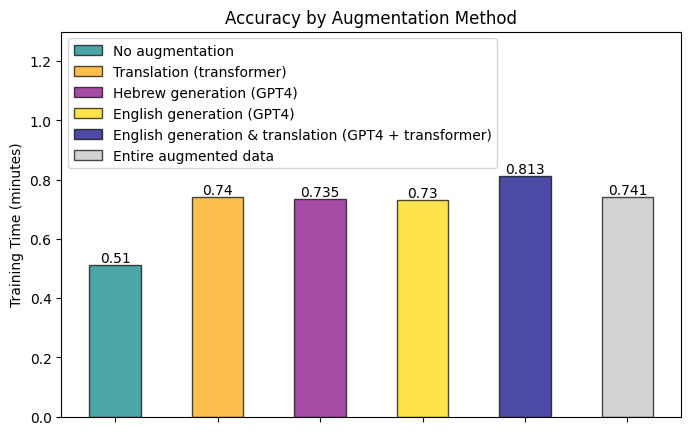

In [9]:
values = [0.51, 0.7402, 0.7348, 0.7301, 0.813, 0.741]
names = ['No augmentation', 'Translation (transformer)', 'Hebrew generation (GPT4)', 'English generation (GPT4)', 'English generation & translation (GPT4 + transformer)', 'Entire augmented data']
title = 'Accuracy by Augmentation Method'
x_label = 'Augmentation Method'
y_label = 'Training Time (minutes)'
colors = ['teal', 'orange', 'purple', 'gold', 'navy', 'silver']

bar_plot(values, names, title, x_label, y_label, colors, use_legend_instead=True, ylim=(0, 1.3))